# Ungraded Lab: Improving Computer Vision Accuracy using Convolutions

Shallow Neural Network
In the previous lessons, you saw how to do fashion recognition using a neural network containing three layers -- the input layer (in the shape of the data), the output layer (in the shape of the desired output) and only one hidden layer. You experimented with the impact of different sizes of hidden layer, number of training epochs etc on the final accuracy. For convenience, here's the entire code again. Run it and take a note of the test accuracy that is printed out at the end.

In [1]:
import tensorflow as tf

In [3]:
fmnist=tf.keras.datasets.fashion_mnist

In [4]:
(train_images,train_labels),(test_images,test_labels)=fmnist.load_data()

In [5]:
train_images=train_images/255.0
test_images=test_images/255.0

In [11]:
model=tf.keras.models.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28,28)),
        tf.keras.layers.Dense(128,activation=tf.nn.relu),
        tf.keras.layers.Dense(10,activation=tf.nn.softmax)
    ]
)
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.fit(train_images,train_labels,epochs=5)
test_loss=model.evaluate(test_images,test_labels)

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4992 - accuracy: 0.8243
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3754 - accuracy: 0.8655
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3374 - accuracy: 0.8779
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3134 - accuracy: 0.8850
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.3739 - accuracy: 0.8661


In [12]:
print(test_loss)

[0.3739413917064667, 0.866100013256073]


# Convolutional Neural Network
In the model above, your accuracy will probably be about 89% on training and 87% on validation. Not bad. But how do you make that even better? One way is to use something called convolutions. We're not going into the details of convolutions in this notebook (please see resources in the classroom), but the ultimate concept is that they narrow down the content of the image to focus on specific parts and this will likely improve the model accuracy.

If you've ever done image processing using a filter (like this)), then convolutions will look very familiar. In short, you take an array (usually 3x3 or 5x5) and scan it over the entire image. By changing the underlying pixels based on the formula within that matrix, you can do things like edge detection. So, for example, if you look at the above link, you'll see a 3x3 matrix that is defined for edge detection where the middle cell is 8, and all of its neighbors are -1. In this case, for each pixel, you would multiply its value by 8, then subtract the value of each neighbor. Do this for every pixel, and you'll end up with a new image that has the edges enhanced.

This is perfect for computer vision because it often highlights features that distinguish one item from another. Moreover, the amount of information needed is then much less because you'll just train on the highlighted features.

That's the concept of Convolutional Neural Networks. Add some layers to do convolution before you have the dense layers, and then the information going to the dense layers is more focused and possibly more accurate.

Run the code below. This is the same neural network as earlier, but this time with Convolution and MaxPooling layers added first. It will take longer, but look at the impact on the accuracy.

In [43]:
model=tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(28,28,1)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dense(10,activation='softmax')
    ]
)

In [44]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 800)               0         
                                                                 
 dense_16 (Dense)            (None, 128)              

In [45]:
class myCallback(tf.keras.callbacks.Callback):
    def on_batch_end(self,epoch,logs={}):
        if(logs.get('loss') is not None and logs.get('loss')<0.25):
            print('\n Loss is lower than 0.25 so cancelling training!')
            self.model.stop_training=True
callback=myCallback()      
        

In [46]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.fit(train_images,train_labels,epochs=5,callbacks=[callback])
test_loss=model.evaluate(test_images,test_labels)

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4730 - accuracy: 0.8275
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3188 - accuracy: 0.8831
Epoch 3/5
   1/1875 [..............................] - ETA: 13s - loss: 0.2675 - accuracy: 0.8750
 Loss is lower than 0.25 so cancelling training!
313/313 [==============================] - 1s 2ms/step - loss: 0.3137 - accuracy: 0.8878


In [47]:
test_loss

[0.3137229382991791, 0.8877999782562256]

# Visualizing the Convolutions and Pooling

Let's explore how to show the convolutions graphically. The cell below prints the first 100 labels in the test set, and you can see that the ones at index 0, index 23 and index 28 are all the same value (i.e. 9). They're all shoes. Let's take a look at the result of running the convolution on each, and you'll begin to see common features between them emerge. Now, when the dense layer is training on that data, it's working with a lot less, and it's perhaps finding a commonality between shoes based on this convolution/pooling combination.

In [48]:
import matplotlib.pyplot as plt
from tensorflow.keras import models 

1/1 [==============================] - 0s 18ms/step


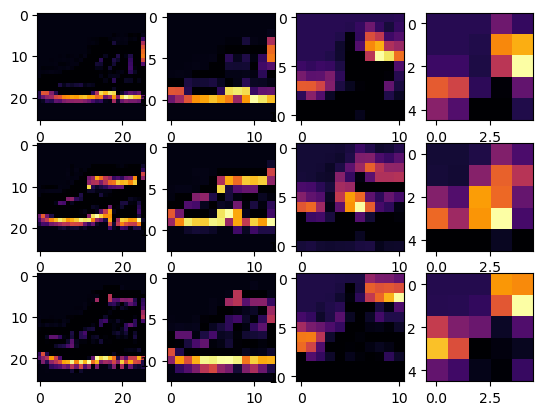

In [49]:
f, axarr = plt.subplots(3,4)
FIRST_IMAGE=0
SECOND_IMAGE=23
THIRD_IMAGE=28
CONVOLUTION_NUMBER = 1

layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)

for x in range(0,4):
  f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[0,x].grid(False)
  
  f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[1,x].grid(False)
  
  f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[2,x].grid(False)

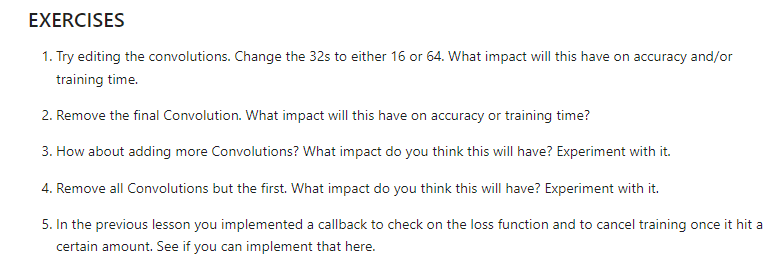